In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Problem 4.a: Gisette dataset

In [129]:
# Define the FSA class with usual functions
class LogitBoostClassifier:
    def __init__(self):
        
        #initialize parameters
        self.boosted_iterations = [10, 30, 100, 300, 500]
        self.train_errs = []
        self.test_errs = []
        self.k300_train_loss = []
    
    
    def sigmoid(self, z):
        ''' 
        Sigmoid function

        Parameters:
        z : int, float or numpy array

        Returns:
        the sigmoid function applied to each element in the array
        '''
        return 1 / (1 + np.exp(-z))
    
    
    def logistic_loss(self, ytr, H):
        return np.sum(np.log(1 + np.exp(-2 * np.multiply(ytr, H))))

    
    def fit(self, X, y, X_test, y_test):
        '''
        Fit data to the FSA model
        
        Parameters:
        X_ : 2D Regressor matrix (num_obs, num_feats)
        y_ : 1D array of labels {0, 1}
        
        Returns:
        training loss, training errors, test errors
        '''
        num_obs, num_feats = X.shape
        
        #start with b0 = 0
        
        
        #loop through boosted iteration numbers (10, 30, 100, 300, 500) 
        for i in range(5):
            self.betas = np.zeros(num_feats)
            for k in range(self.boosted_iterations[i]):

                #initial logitboost setup
                H = np.dot(X, self.betas)
                probs = self.sigmoid(2 * H)
                weights = probs * (1 - probs)
                weights[np.abs(weights) < 1.e-20] = 1.e-20 #ensure no calculation problems by setting bottom limit
                z = np.divide((0.5 * (y + 1)) - probs, weights)

                #coefficient and newloss matrices
                coef_mat = np.matrix(np.zeros((2, num_feats - 1)))
                min_loss, min_index = np.inf, 0

                #loop through features to find best WLS of z on x with w
                for j in range(num_feats - 1):
                    Xj = X[:, j + 1]
                    #calculate WLS features manually for speedup
                    weights_sum = np.sum(weights)
                    weights_xj = np.dot(weights, Xj)
                    weights_xjsq = np.dot(weights, Xj ** 2)
                    weights_z = np.dot(weights, z)
                    weights_xj_z = np.dot(np.multiply(weights, Xj), z)

                    #check if the determinant is 0
                    if (weights_sum * weights_xjsq == weights_xj ** 2):
                        betas_j = np.matrix([[weights_z / weights_sum], [0]])
                    else:
                        betas_j = (1 / (weights_sum * weights_xjsq - weights_xj**2)) \
                                  * np.matrix([[weights_xjsq * weights_z - weights_xj * weights_xj_z],
                                              [weights_sum * weights_xj_z - weights_xj * weights_z]])
                    #update H
                    Hj = H + 0.5 * (betas_j[0] + np.multiply(betas_j[1], Xj))
                    loss_j = self.logistic_loss(y, Hj)
                    coef_mat[:, j] = betas_j

                    #choose the lowest j
                    if loss_j < min_loss:
                        min_index = j
                        min_loss = loss_j

                self.betas[0] += 0.5 * coef_mat[0, min_index]
                self.betas[min_index + 1] = self.betas[min_index + 1] + 0.5 * coef_mat[1, min_index]
                #self.loss.append(min_loss)
                #Calculate training loss for k=300 specifically
                if i == 3:
                    self.k300_train_loss.append(min_loss)

                #Capture the errors of the last iteration
                if (k == self.boosted_iterations[i] - 1):
                    self.train_errs.append(1 - self.score(X,y))
                    self.test_errs.append(1 - self.score(X_test, y_test))

    
    def predict_proba(self, X):

        z = np.dot(X, self.betas)
        probabilities = np.sign(z)

        return probabilities
    
    
    def predict(self, X, threshold=0.5):
        # Thresholding probability to predict binary values
        binary_predictions = np.array(list(map(lambda x: 1 if x > threshold else 0, self.predict_proba(X))))
        
        return binary_predictions
    
    
    def score(self, X, y_true):
        #classification accuracy
        y_pred = self.predict_proba(X)
        acc = accuracy_score(y_true, y_pred)
        
        return acc

In [85]:
gis_train = pd.read_csv("../datasets/Gisette/gisette_train.data", sep = ' ', header=None).dropna(axis=1).values
gis_train_labels = np.ravel(pd.read_csv("../datasets/Gisette/gisette_train.labels", sep = ' ', header=None).values)
gis_test = pd.read_csv("../datasets/Gisette/gisette_valid.data", sep = ' ', header=None).dropna(axis=1).values
gis_test_labels = np.ravel(pd.read_csv("../datasets/Gisette/gisette_valid.labels", sep = ' ', header=None).values)

In [86]:
#Data preprocessing to add 1s in both matrices
intercept_gis_train = np.ones((gis_train.shape[0], 1))
intercept_gis_test = np.ones((gis_test.shape[0], 1))
gis_train = np.hstack((intercept_gis_train, gis_train))
gis_test = np.hstack((intercept_gis_test, gis_test))

In [130]:
gis_model = LogitBoostClassifier()
gis_model.fit(gis_train, gis_train_labels, gis_test, gis_test_labels)

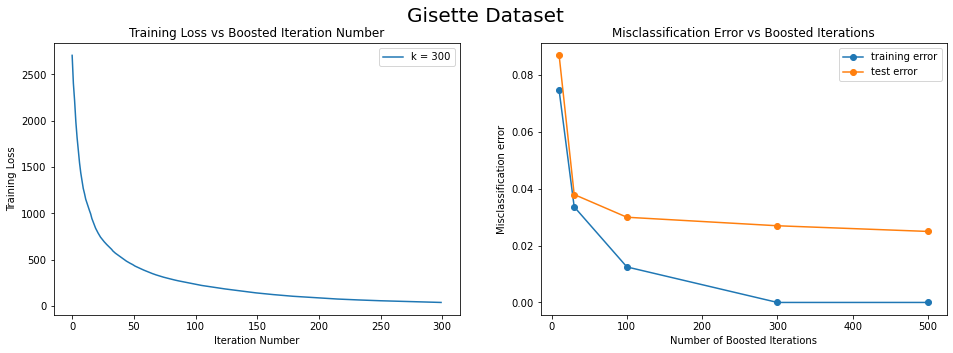

In [162]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))


axs[0].plot(range(300), gis_model.k300_train_loss, label= "k = 300")
axs[0].set_xlabel("Iteration Number")
axs[0].set_ylabel("Training Loss")
axs[0].set_title("Training Loss vs Boosted Iteration Number")
axs[0].legend()

axs[1].plot(gis_model.boosted_iterations, gis_model.train_errs, '-o', label = "training error")
axs[1].plot(gis_model.boosted_iterations, gis_model.test_errs, '-o', label = "test error")
axs[1].set_xlabel("Number of Boosted Iterations")
axs[1].set_ylabel("Misclassification error")
axs[1].set_title("Misclassification Error vs Boosted Iterations")
axs[1].legend()
fig.suptitle("Gisette Dataset", fontsize = 20)

plt.savefig("Gisette.png")
plt.show()

In [178]:
gis_info = {"K": gis_model.boosted_iterations,
            "Train Error": gis_model.train_errs,
            "Test Error": gis_model.test_errs,
            }
gis_df = pd.DataFrame(gis_info)
gis_df.sort_values(['K'], ascending=True)

,K,Train Error,Test Error
0,10,0.074667,0.087
1,30,0.033667,0.038
2,100,0.012500,0.030
3,300,0.000000,0.027
4,500,0.000000,0.025


# Problem 4.b: Dexter dataset

In [159]:
#Read in the data for dexter dataset
dex_train = pd.read_csv("../datasets/dexter/dexter_train.csv", header=None).dropna(axis=1).values
dex_train_labels = np.ravel(pd.read_csv("../datasets/dexter/dexter_train.labels", sep = ' ', header=None).values)
dex_test = pd.read_csv("../datasets/dexter/dexter_valid.csv", header=None).dropna(axis=1).values
dex_test_labels = np.ravel(pd.read_csv("../datasets/dexter/dexter_valid.labels", sep = ' ', header=None).values)

In [160]:
#Data preprocessing to add 1s in both train and test matrices
intercept_dex_train = np.ones((dex_train.shape[0], 1))
intercept_dex_test = np.ones((dex_test.shape[0], 1))
dex_train = np.hstack((intercept_dex_train, dex_train))
dex_test = np.hstack((intercept_dex_test, dex_test))

In [163]:
dex_model = LogitBoostClassifier()
dex_model.fit(dex_train, dex_train_labels, dex_test, dex_test_labels)

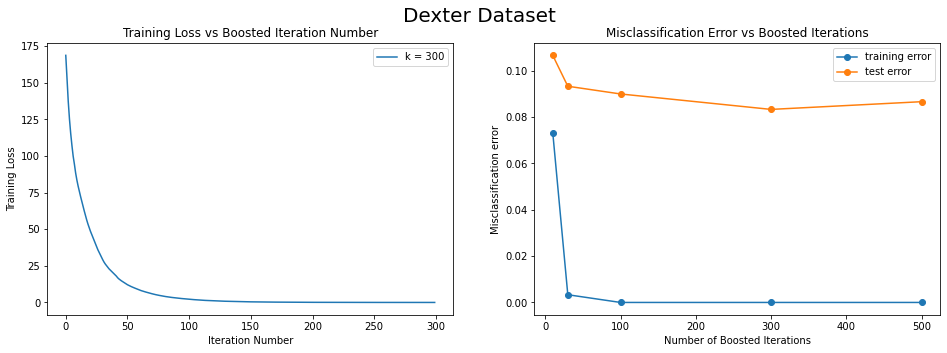

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].plot(range(300), dex_model.k300_train_loss, label= "k = 300")
axs[0].set_xlabel("Iteration Number")
axs[0].set_ylabel("Training Loss")
axs[0].set_title("Training Loss vs Boosted Iteration Number")
axs[0].legend()

axs[1].plot(dex_model.boosted_iterations, dex_model.train_errs, '-o', label = "training error")
axs[1].plot(dex_model.boosted_iterations, dex_model.test_errs, '-o', label = "test error")
axs[1].set_xlabel("Number of Boosted Iterations")
axs[1].set_ylabel("Misclassification error")
axs[1].set_title("Misclassification Error vs Boosted Iterations")
axs[1].legend()
fig.suptitle("Dexter Dataset", fontsize = 20)

plt.savefig("Dexter.png")
plt.show()

In [175]:
dex_info = {"K": dex_model.boosted_iterations,
            "Train Error": dex_model.train_errs,
            "Test Error": dex_model.test_errs,
            }
dex_df = pd.DataFrame(dex_info)
dex_df.sort_values(['K'], ascending=True)

,K,Train Error,Test Error
0,10,0.073333,0.106667
1,30,0.003333,0.093333
2,100,0.000000,0.090000
3,300,0.000000,0.083333
4,500,0.000000,0.086667


# Problem 4.c: Madelon dataset

In [166]:
mad_train = pd.read_csv("../datasets/madelon/madelon_train.data", sep=' ', header=None).dropna(axis=1).values
mad_train_labels = np.ravel(pd.read_csv("../datasets/madelon/madelon_train.labels", sep=' ', header=None).dropna(axis=1).values)
mad_test = pd.read_csv("../datasets/madelon/madelon_valid.data", sep = ' ', header=None).dropna(axis=1).values
mad_test_labels = np.ravel(pd.read_csv("../datasets/madelon/madelon_valid.labels", sep=' ', header=None).dropna(axis=1).values)

In [167]:
#Data preprocessing to add 1s in both train and test matrices
intercept_mad_train = np.ones((mad_train.shape[0], 1))
intercept_mad_test = np.ones((mad_test.shape[0], 1))
mad_train = np.hstack((intercept_mad_train, mad_train))
mad_test = np.hstack((intercept_mad_test, mad_test))

In [168]:
mad_model = LogitBoostClassifier()
mad_model.fit(mad_train, mad_train_labels, mad_test, mad_test_labels)

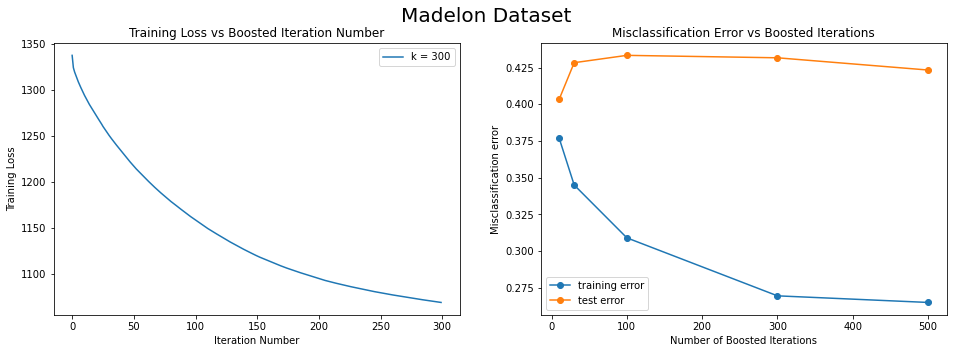

In [170]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].plot(range(300), mad_model.k300_train_loss, label= "k = 300")
axs[0].set_xlabel("Iteration Number")
axs[0].set_ylabel("Training Loss")
axs[0].set_title("Training Loss vs Boosted Iteration Number")
axs[0].legend()

axs[1].plot(mad_model.boosted_iterations, mad_model.train_errs, '-o', label = "training error")
axs[1].plot(mad_model.boosted_iterations, mad_model.test_errs, '-o', label = "test error")
axs[1].set_xlabel("Number of Boosted Iterations")
axs[1].set_ylabel("Misclassification error")
axs[1].set_title("Misclassification Error vs Boosted Iterations")
axs[1].legend()
fig.suptitle("Madelon Dataset", fontsize = 20)

plt.savefig("Madelon.png")
plt.show()

In [180]:
mad_info = {"K": mad_model.boosted_iterations,
            "Train Error": mad_model.train_errs,
            "Test Error": mad_model.test_errs,
            }
mad_df = pd.DataFrame(mad_info)
mad_df.sort_values(['K'], ascending=True)

,K,Train Error,Test Error
0,10,0.3770,0.403333
1,30,0.3450,0.428333
2,100,0.3090,0.433333
3,300,0.2695,0.431667
4,500,0.2650,0.423333
